https://morvanzhou.github.io/tutorials/machine-learning/torch/4-01-CNN/

# 要点

卷积神经网络目前被广泛地应用在图像识别上，已经有层出不穷地应用。

接下来分析一下手写数字地CNN:

# MNIST手写数据

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision #数据库模块
import matplotlib.pyplot as plt

torch.manual_seed(1)  #reproducible

# Hyper Parameters 超参数
EPOCH = 1 # 训练整批数据多少次，为了节约时间，我们只训练一次
BATCH_SIZE = 50
LR = 0.001 # 学习率
DOWNLOAD_MNIST = True # 如果已经下载好了mnist数据就写上False

train_data = torchvision.datasets.MNIST(
    root='./mnist/',  # 保存或者提取位置
    train=True, # this is training data
    transform=torchvision.transforms.ToTensor(),
    # 转换PIL.Image or numpy.ndarray成torch.FloatTensor (C x H x W)，
    # 训练地时候normalize成[0.0,1.0]区间
    download=DOWNLOAD_MNIST,
)

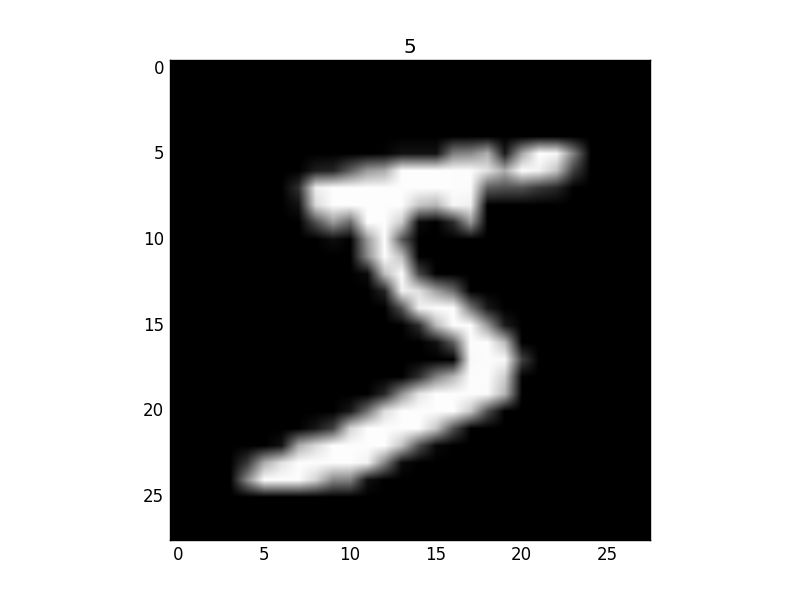

黑色的地方的值都是0，白色的地方的值大于0。

同样，我们除了训练数据，还给一些测试数据，测试看看它有没有训练好。

In [2]:
test_data = torchvision.datasets.MNIST(root='./mnist/',train=False)

# 批训练 500 samples，1 channel，28x28 (50,1,28,28)
train_loader = Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)

# 为了节约时间，我们测试时只测试前2000个
test_x = torch.unsqueeze(test_data.test_data,dim=1).type(torch.FloatTensor)[:2000]/255
# shape from (2000,28,28)to(2000,1,28,28),value in range(0,1)
test_y = test_data.test_labels[:2000]

# CNN模型

和以前一样, 我们用一个 class 来建立 CNN 模型. 这个 CNN 整体流程是 卷积(`Conv2d`) -> 激励函数(`ReLU`) -> 池化, 向下采样 (`MaxPooling`) -> 再来一遍 -> 展平多维的卷积成的特征图 -> 接入全连接层 (`Linear`) -> 输出

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential( 
            #input shape (1,28,28)
            nn.Conv2d(
                in_channels=1, # input height
                out_channels=16, # n_filters
                kernel_size=5, #filter size
                stride=1, # filter movement/step
                # 如果想要conv2d出来的图片长宽没有变化，padding=(kernel_size-1)/2
                #当stride=1时，output shape (16,28,28)
                padding=2, 
            ),
            nn.ReLU(),  #activation
            # 在2x2空间里向下采样，output shape (16,14,14)
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            # input shape (16,14,14)
            nn.Conv2d(16,32,5,1,2),  # output shape (32,14,14)
            nn.ReLU(),  # active
            nn.MaxPool2d(2), #output shape (32,7,7)
        )
        self.out = nn.Linear(32*7*7,10) # fully connected layer, output 10 classes
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(x.size(0),-1) #展平多维的卷积图层 (batch_size,32*7*7)
        output=self.out(x)
        return output
    
cnn=CNN()
print(cnn) # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


# 训练

下面我们开始训练, 将 `x` `y` 都用 `Variable` 包起来, 然后放入 `cnn` 中计算 `output`, 最后再计算误差. 下面代码省略了计算精确度 `accuracy` 的部分

In [4]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # 分配 batch data, normalize x when iterate train_loader
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients            

"""
...

Epoch:  0 | train loss: 0.0306 | test accuracy: 0.97

Epoch:  0 | train loss: 0.0147 | test accuracy: 0.98

Epoch:  0 | train loss: 0.0427 | test accuracy: 0.98

Epoch:  0 | train loss: 0.0078 | test accuracy: 0.98

"""

最后我们再来取10个数据, 看看预测的值到底对不对:

In [5]:
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


# 完整代码加可视化

torch.Size([60000, 28, 28])
torch.Size([60000])


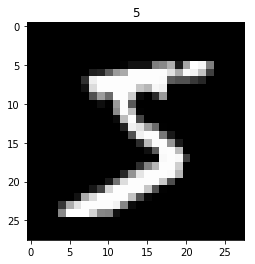

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3202 | test accuracy: 0.10


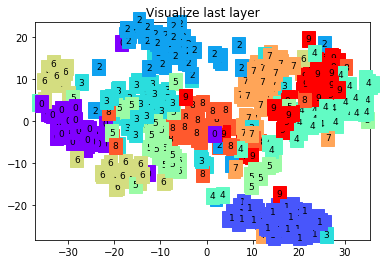

Epoch:  0 | train loss: 0.3962 | test accuracy: 0.84


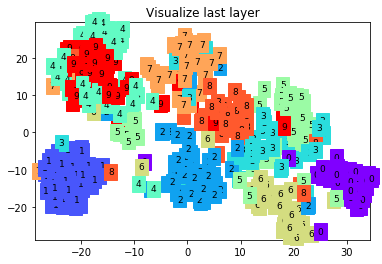

Epoch:  0 | train loss: 0.2627 | test accuracy: 0.88


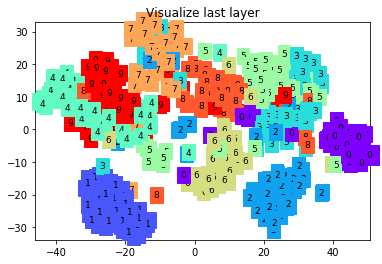

Epoch:  0 | train loss: 0.3614 | test accuracy: 0.93


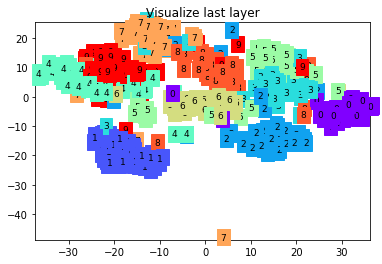

Epoch:  0 | train loss: 0.1989 | test accuracy: 0.94


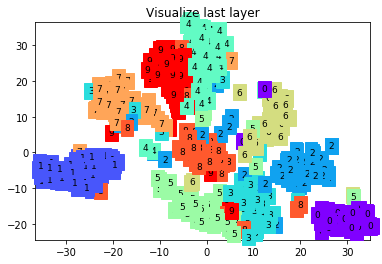

Epoch:  0 | train loss: 0.2275 | test accuracy: 0.95


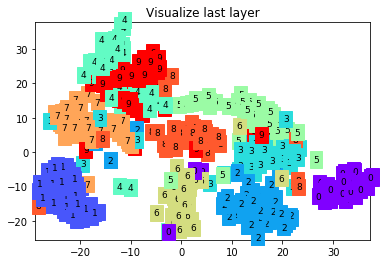

Epoch:  0 | train loss: 0.1416 | test accuracy: 0.95


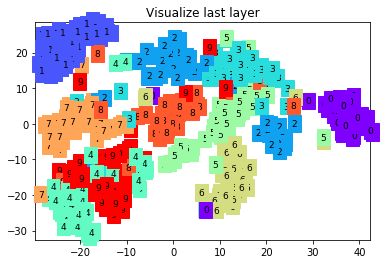

Epoch:  0 | train loss: 0.0858 | test accuracy: 0.95


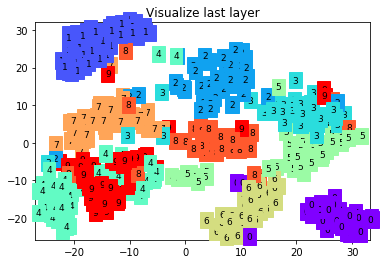

Epoch:  0 | train loss: 0.1431 | test accuracy: 0.96


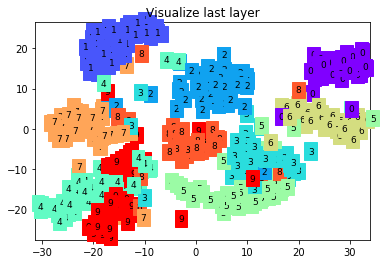

Epoch:  0 | train loss: 0.0988 | test accuracy: 0.96


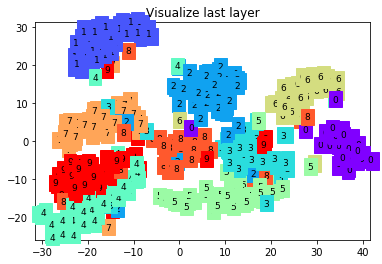

Epoch:  0 | train loss: 0.2111 | test accuracy: 0.97


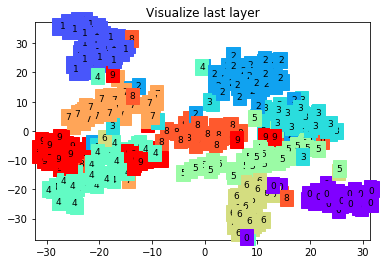

Epoch:  0 | train loss: 0.0371 | test accuracy: 0.96


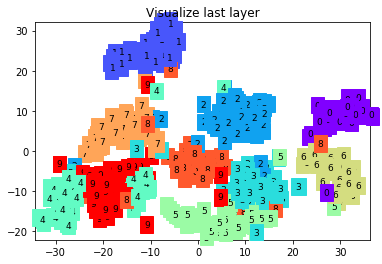

Epoch:  0 | train loss: 0.1561 | test accuracy: 0.96


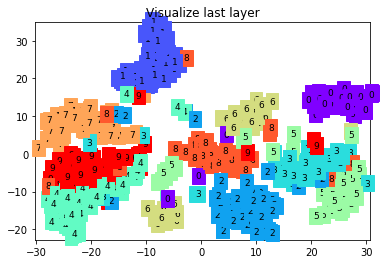

Epoch:  0 | train loss: 0.0530 | test accuracy: 0.97


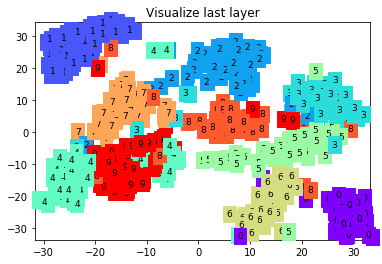

Epoch:  0 | train loss: 0.0451 | test accuracy: 0.97


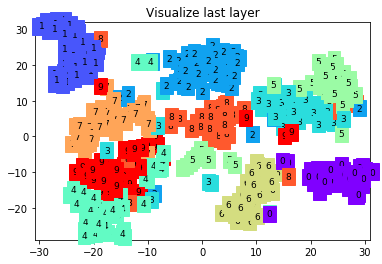

Epoch:  0 | train loss: 0.0287 | test accuracy: 0.96


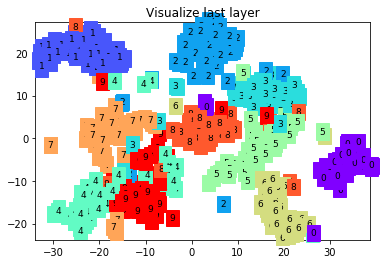

Epoch:  0 | train loss: 0.2611 | test accuracy: 0.97


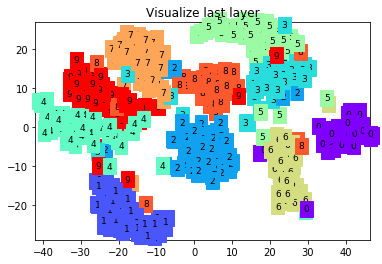

Epoch:  0 | train loss: 0.0779 | test accuracy: 0.97


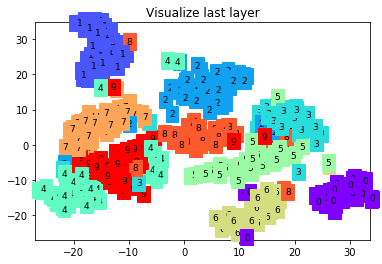

Epoch:  0 | train loss: 0.0965 | test accuracy: 0.97


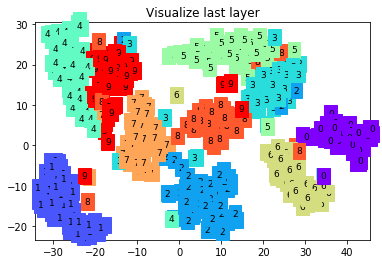

Epoch:  0 | train loss: 0.0599 | test accuracy: 0.98


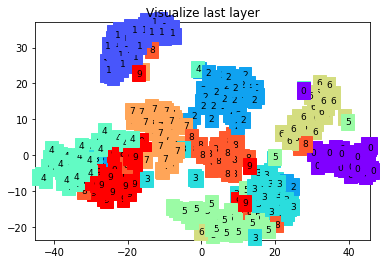

Epoch:  0 | train loss: 0.0718 | test accuracy: 0.98


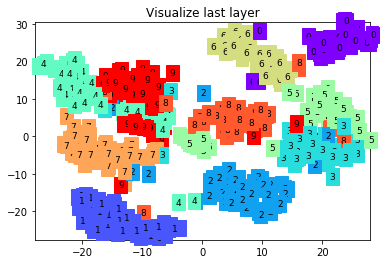

Epoch:  0 | train loss: 0.0940 | test accuracy: 0.98


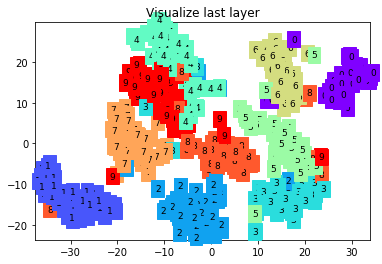

Epoch:  0 | train loss: 0.0928 | test accuracy: 0.98


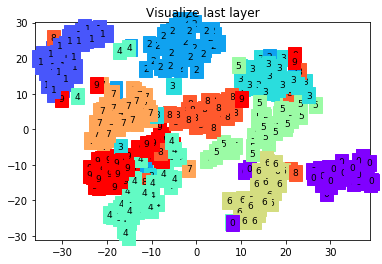

Epoch:  0 | train loss: 0.0117 | test accuracy: 0.98


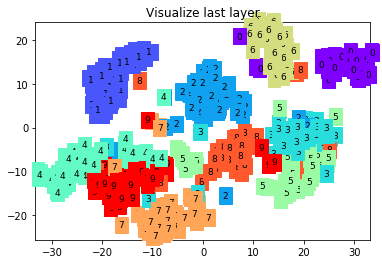

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [6]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
torchvision
matplotlib
"""
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False


# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization


cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')